# Project: Social Media Data Analysis
- Reproducing "The Anatomy of a Scientific Rumour", M. De Domenico, A. Lima, P. Mougel and M. Musolesi (2013)
- Data source: http://snap.stanford.edu/data/higgs-twitter.html
- Project by Raphaela Keßler, 07.09.2023

In [7]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import random

## 1. Load Data

In [8]:
file_path = "higgs-activity_time.txt"  
column_names = ["userA", "userB", "timestamp", "interaction"]
df = pd.read_csv(file_path, names=column_names, delimiter=' ')

In [9]:
df.head()

,userA,userB,timestamp,interaction
0,223789,213163,1341100972,MT
1,223789,213163,1341100972,RE
2,376989,50329,1341101181,RT
3,26375,168366,1341101183,MT
4,376989,13813,1341101192,RT


## 2. Preprocessing

In [10]:
# convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['timestamp'].dt.date

In [11]:
df["timestamp"].describe()

count                           563069
mean     2012-07-04 17:52:07.258142720
min                2012-07-01 00:02:52
25%                2012-07-04 06:55:43
50%                2012-07-04 13:01:27
75%                2012-07-05 02:36:26
max                2012-07-07 23:59:53
Name: timestamp, dtype: object

In [12]:
# Calculate interactivity time
df.sort_values(by=['userA', 'timestamp'], inplace=True)

# Group the data by user
grouped_data = df.groupby('userA')

# Create a list to store the results for each user
interactivity_data = []

# Iterate through each user's data
for user, user_data in grouped_data:
    
    # Calculate inter-activity times for the user
    interactivity_time = user_data['timestamp'].diff().fillna("NA")
    
    # Store user and interactivity time in a dictionary
    for interactivity, timestamp, interaction, date, userB in zip(interactivity_time, user_data['timestamp'], user_data['interaction'], user_data['date'], user_data['userB']):
        user_interactivity = {
            'userA':user,
            'userB':userB,
            'interactivity_time': interactivity,
            'timestamp': timestamp,
            'date': date,
            'interaction': interaction
        }
    
        # Append the dictionary to the list
        interactivity_data.append(user_interactivity)

# Create a DataFrame from the list of dictionaries
interactivity_df = pd.DataFrame(interactivity_data)

In [13]:
interactivity_df.head()

,userA,userB,interactivity_time,timestamp,date,interaction
0,2,314,NA,2012-07-07 15:16:50,2012-07-07,RT
1,3,291,NA,2012-07-04 09:57:30,2012-07-04,RT
2,4,88,NA,2012-07-01 15:14:36,2012-07-01,MT
3,4,26486,0 days 00:00:00,2012-07-01 15:14:36,2012-07-01,RT
4,4,38960,2 days 13:42:07,2012-07-04 04:56:43,2012-07-04,RT


In [14]:
# Define the time periods
periods = {
    'Period I': ('2012-07-01', '2012-07-02'),
    'Period II': ('2012-07-02', '2012-07-03'),
    'Period III': ('2012-07-03', '2012-07-04'),
    'Period IV': ('2012-07-04', '2012-07-07')
}

# Filter data within the specified time periods
filtered_data = []

for period_name, (start_date, end_date) in periods.items():
    period_data = interactivity_df[(interactivity_df['timestamp'] >= start_date) & (interactivity_df['timestamp'] < end_date)]
    filtered_data.append((period_name, period_data))

# Create a dictionary to store the active users for each period
active_users = []

# Identify active users for each period
for period_name, period_data in filtered_data:
    active_users_dict = {}
    active_users_dict["active_user"] = period_data['userA'].nunique()
    active_users_dict["active_user_ratio"] = (period_data['userA'].nunique() / (period_data['userA'].nunique() + period_data['userB'].nunique()))
    active_users.append(active_users_dict)

In [15]:
active_users = pd.DataFrame(active_users)
active_users.head()

,active_user,active_user_ratio
0,2650,0.780330
1,10431,0.800722
2,21153,0.820361
3,255240,0.823628


In [16]:
# Transfer to pandas df
filtered_df = pd.concat([df.assign(Period=period) for period, df in filtered_data])

# Reset the index
filtered_df.reset_index(drop=True, inplace=True)

print(filtered_df.head())
print(filtered_df.info())

   userA  userB interactivity_time           timestamp        date   
0      4     88                 NA 2012-07-01 15:14:36  2012-07-01  \
1      4  26486    0 days 00:00:00 2012-07-01 15:14:36  2012-07-01   
2    107      4                 NA 2012-07-01 19:48:25  2012-07-01   
3    107    510    0 days 00:00:00 2012-07-01 19:48:25  2012-07-01   
4    167     88                 NA 2012-07-01 15:17:07  2012-07-01   

  interaction    Period  
0          MT  Period I  
1          RT  Period I  
2          MT  Period I  
3          RT  Period I  
4          MT  Period I  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546223 entries, 0 to 546222
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   userA               546223 non-null  int64         
 1   userB               546223 non-null  int64         
 2   interactivity_time  546223 non-null  object        
 3   timestamp           546

In [17]:
for key, value in active_users.items():
    print(f"active user in {key}:", len(value))

active user in active_user: 4
active user in active_user_ratio: 4


In [18]:
# configure font 
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('tableau-colorblind10')

## 3. Descriptive Plots

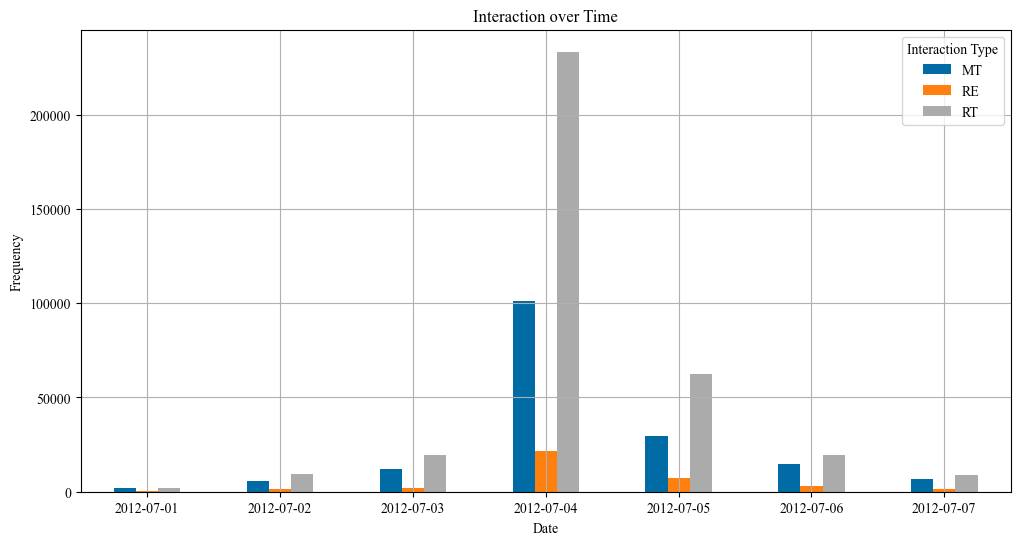

In [15]:
# plot to show interaction over time
interaction_over_date = df.groupby(['date', 'interaction']).size().unstack()

interaction_over_date.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Interaction over Time')
plt.legend(title='Interaction Type')
plt.grid()
plt.xticks(rotation=360)  
plt.savefig('interaction_over_date.png')

In [16]:
interaction_over_date

interaction,MT,RE,RT
date,,,
2012-07-01,1749,285,2136
2012-07-02,5600,1226,9248
2012-07-03,11860,2216,19426
2012-07-04,101279,21778,233331
2012-07-05,29329,7021,62292
2012-07-06,14786,3130,19531
2012-07-07,6634,1246,8966


Text(0.5, 1.0, 'Distribution of Interaction Types')

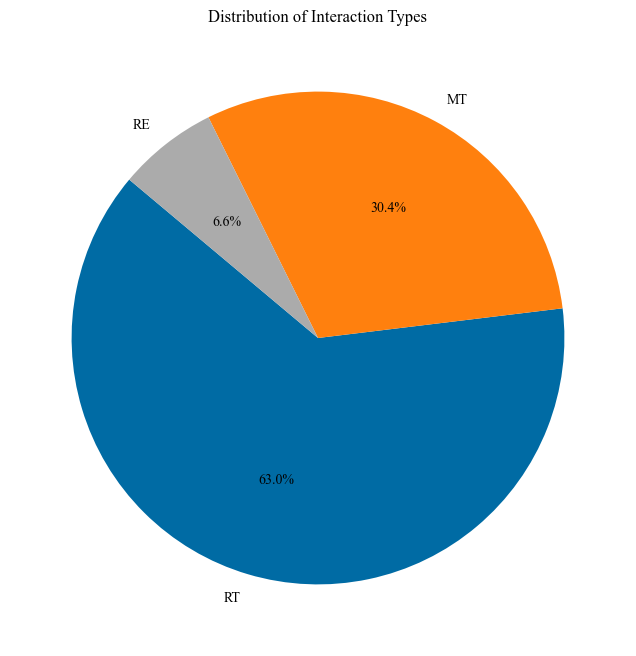

In [17]:
interaction_counts = df['interaction'].value_counts()

# pie chart
plt.figure(figsize=(8, 8))
plt.pie(interaction_counts, labels=interaction_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Interaction Types')

In [18]:
# drop NA and interactivity_time = 0
filtered_df2 = filtered_df[filtered_df['interactivity_time'] != 'NA']
filtered_df2 = filtered_df2[filtered_df2['interactivity_time'] != pd.Timedelta(seconds=0)]

# Reset the index
filtered_df2.reset_index(drop=True, inplace=True)

filtered_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175233 entries, 0 to 175232
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   userA               175233 non-null  int64         
 1   userB               175233 non-null  int64         
 2   interactivity_time  175233 non-null  object        
 3   timestamp           175233 non-null  datetime64[ns]
 4   date                175233 non-null  object        
 5   interaction         175233 non-null  object        
 6   Period              175233 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 9.4+ MB


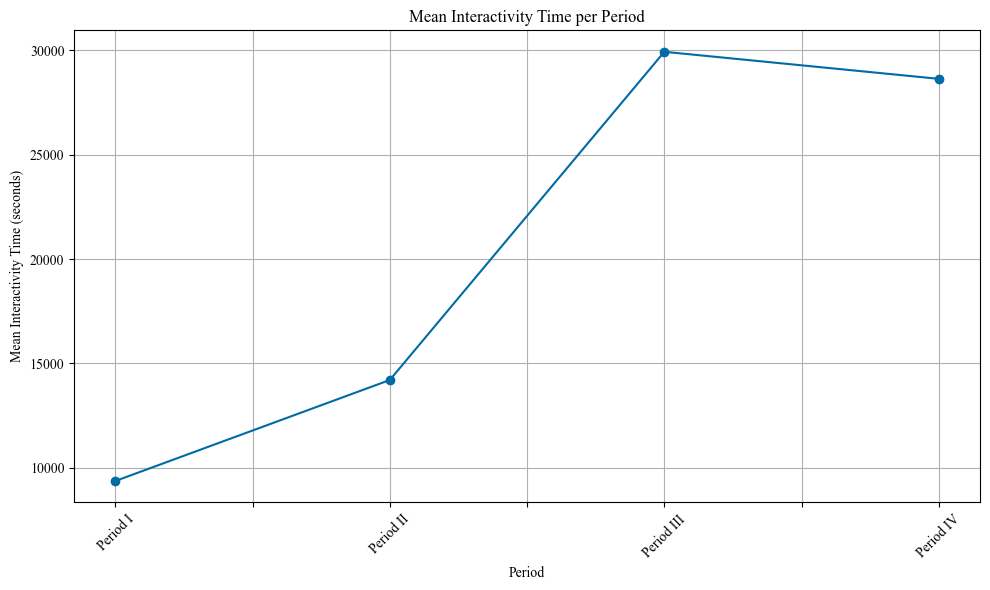

In [19]:
filtered_df2['interactivity_time'] = filtered_df2['interactivity_time'].apply(lambda x: pd.Timedelta(x).total_seconds())

# Group by 'Period' and calculate the mean interactivity_time for each period
period_grouped = filtered_df2.groupby('Period')['interactivity_time'].mean()

# Create a line plot
plt.figure(figsize=(10, 6))
period_grouped.plot(kind='line', marker='o')
plt.ylabel('Mean Interactivity Time (seconds)')
plt.title('Mean Interactivity Time per Period')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('mean_interactivity_time.png')
plt.show()

## 4. Networks

In [59]:
# sample df
sample_df = filtered_df2.sample(n=1000)

In [21]:
# Create a directed graph
G = nx.DiGraph()

In [77]:
# Create nodes for userA and userB columns
G.add_nodes_from(sample_df['userA'], color='black')
G.add_nodes_from(sample_df['userB'], color='skyblue')

# Add edges between userA and userB based on interaction
for _, row in sample_df.iterrows():
    G.add_edge(row['userA'], row['userB'], interaction=row['interaction'], weight=row['interactivity_time']) #


In [78]:
node_colors = [G.nodes[node]['color'] for node in G.nodes]
edge_weights = [G.edges[edge]['weight'] for edge in G.edges]

In [64]:
edge_colors = {
    "RT": "blue",
    "MT": "green",
    "RE": "grey"
}

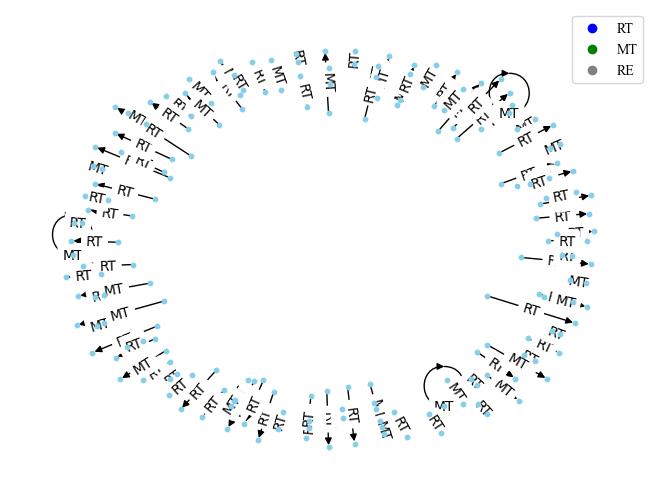

In [41]:
# Draw the graph
pos = nx.spring_layout(G)  
nx.draw(G, pos, node_size=10, node_color='skyblue', font_size=12, font_weight='bold')

# Draw edge labels (interaction types)
edge_labels = nx.get_edge_attributes(G, "interaction")
edge_colors_list = [edge_colors[label] for label in edge_labels.values()]

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Create legend handles and labels based on edge colors
legend_handles = [plt.Line2D([], [], marker='o', color=color, label=label, linestyle='None') for label, color in edge_colors.items()]
plt.legend(handles=legend_handles, loc='best')

# Show the graph
plt.show()

In [53]:
import matplotlib.colors as mcolors

C:\Users\Raphaela\AppData\Local\Temp\ipykernel_9512\4131502659.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.2f}'.format(label) for label in legend_labels])
C:\Users\Raphaela\AppData\Local\Temp\ipykernel_9512\4131502659.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


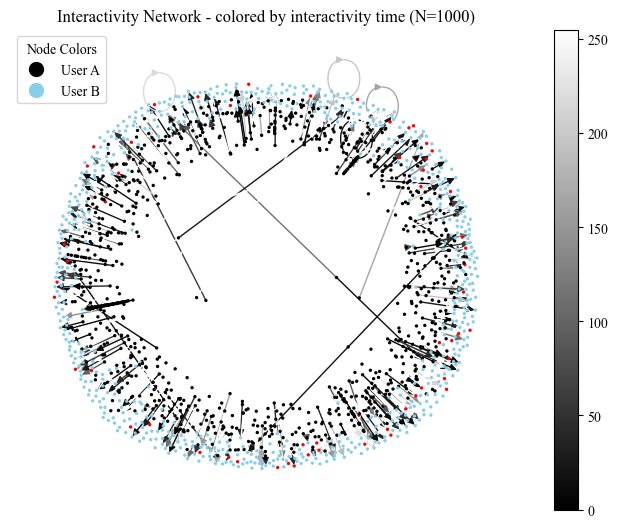

In [79]:
# Get the interactivity_time values to use for edge coloring
edge_colors = [row['interactivity_time'] for _, row in sample_df.iterrows()]

# Create a colormap for edge colors
cmap = plt.get_cmap('gray')

# Define colors and their positions in the gradient
# colors = ['#808080', 'orange', 'blue']
# positions = [0, 0.5, 1.0]

# Create a LinearSegmentedColormap
# cmap = mcolors.LinearSegmentedColormap.from_list('CustomCmap', list(zip(positions, colors)))

num_colors = 256
norm = plt.Normalize(0, num_colors - 1)

# list of colors based on the colormap and normalized values
edge_colors_normalized = [cmap(norm(value)) for value in edge_colors]

# Draw the graph with edge colors
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=False, node_size=2, node_color=[n[1]['color'] for n in G.nodes(data=True)], edge_color=edge_colors_normalized, width=1.0, edge_cmap=cmap, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors))

# edge legend
legend_labels = np.linspace(min(edge_colors), max(edge_colors), num=5)  # You can adjust the number of legend labels as needed
cbar.ax.set_yticklabels(['{:.2f}'.format(label) for label in legend_labels])

# node legend
unique_node_colors = list(set(node_colors))
node_color_labels = ['User A' if color == 'black' else 'User B' for color in unique_node_colors]  # You can customize these labels as needed
node_color_legend = plt.legend(handles=[
    plt.Line2D([], [], marker='o', color='black', markersize=10, linestyle='None', label='User A'),
    plt.Line2D([], [], marker='o', color='skyblue', markersize=10, linestyle='None', label='User B'),
], loc='upper left', title='Node Colors')

# Create a colorbar for the edge colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)

plt.title('Interactivity Network - colored by interactivity time (N=1000)')

plt.savefig('network.png')

plt.show()

In [73]:
# Get the number of nodes (users) and edges (interactions)
num_nodes = len(G.nodes)
num_edges = len(G.edges)

# Calculate average degree (average number of interactions per user)
avg_degree = sum(dict(G.degree()).values()) / num_nodes

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average degree:", avg_degree)


Number of nodes: 1759
Number of edges: 1096
Average degree: 1.2461625923820352


## 5. Model

In [19]:
# Define the Bass Diffusion Model function
def bass_model(t, p, q, m):
    return m * (1 - np.exp(-(p+q)*t)) / (1 + (q/p) * np.exp(-(p+q)*t))

In [20]:
# Convert the 'Period' column to numeric labels
le = LabelEncoder()
filtered_df['Period_Label'] = le.fit_transform(filtered_df['Period'])

In [21]:
# Create dictionaries to store the models and evaluation metrics
models = {}
evaluation_metrics = {}

y_pred_list = []
y_true_list = []

# Define the periods for training and testing
periods = ['Period I', 'Period II', 'Period III', 'Period IV']

# Loop through the periods to create and evaluate the models
for i in range(len(periods) - 1):
    
    # Split the data into training and test sets
    train_data = filtered_df[filtered_df['Period_Label'] == i]
    test_data = filtered_df[filtered_df['Period_Label'] == i+1]
    
    # Train the Bass Model for the current period
    t = train_data['Period_Label']
    m = train_data['userA'].nunique() + train_data['userB'].nunique()
    p = train_data['userA'].nunique() / m
    q = train_data['userA'].nunique()
    
    y_true = test_data['userA'].nunique() / (test_data['userA'].nunique() + test_data['userB'].nunique())
    y_true_list.append(y_true)

    params, _ = curve_fit(bass_model, t, y_true)
    
    y_pred = bass_model(t+1, *params)
    y_pred_list.append(np.mean(y_pred) ) 

C:\Users\Raphaela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [22]:
for i in range(len(periods) - 1):
    print(f'Model {i+1}:')
    print('y true', round(y_true_list[i],3))
    print('y predicted', round(y_pred_list[i], 3))
    print('-----------')


Model 1:
y true 0.801
y predicted 0.762
-----------
Model 2:
y true 0.82
y predicted 0.93
-----------
Model 3:
y true 0.824
y predicted 0.876
-----------


In [31]:
y_true = np.array(y_true_list)  
y_pred = np.array(y_pred_list) 

# Calculate regression metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse) 
r2 = r2_score(y_true, y_pred)

print("Mean Absolute Error:", round(mae,3))
print("Mean Squared Error:", round(mse,3))
print("Root Mean Squared Error:", round(rmse,3))
print("R-squared (R^2):", round(r2,3))

Mean Absolute Error: 0.067
Mean Squared Error: 0.005
Root Mean Squared Error: 0.074
R-squared (R^2): -52.002
